In [1]:

import os.path

import matplotlib.pyplot as plt
import numpy as np
from jedi.parser_utils import function_is_staticmethod
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorboard.notebook import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from farich_functions import *

plt.rcParams['font.size'] = 16

warnings.filterwarnings("ignore")

In [2]:
mu_mass = 105.65
pi_mass = 139.57
ka_mass = 493.68

In [6]:
(100000/0.034)*0.144*(1 - 0.5*.5)

317647.0588235294

In [3]:
filepath = os.path.join("data", "decay_test_ka2.root")
filepath = os.path.join("data", "decay_test_2gamma.root")
filepath = os.path.join("data", "decay_test_KmuKpi_40000_field.root")
filepath = os.path.join("data", "decay_Kmu_50000_field_bin_1.root")
# filepath = os.path.join("data", "mag_field_test.root")
# filepath = os.path.join("data", "fullsim_3particles_40000_ka_bin_3_FARICH_35mm_1000_no_trackers.root")

In [4]:
file = uproot.open(filepath)

In [5]:
primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())

In [6]:
farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array()) # 40% К куда-то пропадают в фариче

In [7]:
x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())
y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())
z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())
m3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.mass'].array())

In [8]:
pi_p = []
mu_p = []
ka_mu_p = []
ka_pi_p = []

e_miss = []
p_miss = []

e_miss_mu = []
p_miss_mu = []
e_miss_pi = []
p_miss_pi = []
smooth = 0.02
for i, primary_particles in enumerate(primary_pdgid):
    
    e_miss.append(3773/2 - (np.sqrt(x3[i][2] ** 2 + y3[i][2] ** 2 + z3[i][2] ** 2 + m3[i][2] ** 2) * 1000) - (np.sqrt(x3[i][3] ** 2 + y3[i][3] ** 2 + z3[i][3] ** 2 + m3[i][3] ** 2) * 1000))
    p_miss.append(np.sqrt((x3[i][1] - x3[i][2] - x3[i][3]) ** 2 + (y3[i][1] - y3[i][2] - y3[i][3]) ** 2 + (z3[i][1] - z3[i][2] - z3[i][3]) ** 2) * 1000)
    p_ka = np.sqrt(x3[i][2] ** 2 + y3[i][2] ** 2 + z3[i][2] ** 2)
    p_mu = np.sqrt(x3[i][3] ** 2 + y3[i][3] ** 2 + z3[i][3] ** 2)
    if primary_particles[3] == 211:
        if np.sqrt(x3[i][4] ** 2 + y3[i][4] ** 2 + z3[i][4] ** 2) > 0:
            e_miss_pi.append(3773/2 - (np.sqrt((p_ka * np.random.normal(loc=1, scale=p_ka*smooth,size=1)[0]) ** 2 + m3[i][2] ** 2) * 1000) - (np.sqrt((p_mu * np.random.normal(loc=1, scale=p_mu*smooth,size=1)[0]) ** 2 + (mu_mass / 1000) ** 2) * 1000))
            p_miss_pi.append(np.sqrt((x3[i][1] * np.random.normal(loc=1, scale=np.abs(x3[i][1])*smooth,size=1)[0] - x3[i][2] * np.random.normal(loc=1, scale=np.abs(x3[i][2])*smooth,size=1)[0]- x3[i][3] * np.random.normal(loc=1, scale=np.abs(x3[i][3])*smooth,size=1)[0]) ** 2 + (y3[i][1] * np.random.normal(loc=1, scale=np.abs(y3[i][1])*smooth,size=1)[0]- y3[i][2] * np.random.normal(loc=1, scale=np.abs(y3[i][2])*smooth,size=1)[0] - y3[i][3] * np.random.normal(loc=1, scale=np.abs(y3[i][3])*smooth,size=1)[0]) ** 2 + (z3[i][1] * np.random.normal(loc=1, scale=np.abs(z3[i][1])*smooth,size=1)[0] - z3[i][2] * np.random.normal(loc=1, scale=np.abs(z3[i][2])*smooth,size=1)[0] - z3[i][3] * np.random.normal(loc=1, scale=np.abs(z3[i][3])*smooth,size=1)[0]) ** 2) * 1000)
    if primary_particles[3] == -13:
        if not (22 in primary_particles):
            e_miss_mu.append(3773/2 - (np.sqrt((p_ka * np.random.normal(loc=1, scale=p_ka*smooth,size=1)[0]) ** 2 + m3[i][2] ** 2) * 1000) - (np.sqrt((p_mu * np.random.normal(loc=1, scale=p_mu*smooth,size=1)[0]) ** 2 + (m3[i][3]) ** 2) * 1000))
            p_miss_mu.append(np.sqrt((x3[i][1] * np.random.normal(loc=1, scale=np.abs(x3[i][1])*smooth,size=1)[0] - x3[i][2] * np.random.normal(loc=1, scale=np.abs(x3[i][2])*smooth,size=1)[0]- x3[i][3] * np.random.normal(loc=1, scale=np.abs(x3[i][3])*smooth,size=1)[0]) ** 2 + (y3[i][1] * np.random.normal(loc=1, scale=np.abs(y3[i][1])*smooth,size=1)[0]- y3[i][2] * np.random.normal(loc=1, scale=np.abs(y3[i][2])*smooth,size=1)[0] - y3[i][3] * np.random.normal(loc=1, scale=np.abs(y3[i][3])*smooth,size=1)[0]) ** 2 + (z3[i][1] * np.random.normal(loc=1, scale=np.abs(z3[i][1])*smooth,size=1)[0] - z3[i][2] * np.random.normal(loc=1, scale=np.abs(z3[i][2])*smooth,size=1)[0] - z3[i][3] * np.random.normal(loc=1, scale=np.abs(z3[i][3])*smooth,size=1)[0]) ** 2) * 1000)
e_miss = np.array(e_miss)
p_miss = np.array(p_miss)
e_miss_mu = np.array(e_miss_mu)
p_miss_mu = np.array(p_miss_mu)
e_miss_pi = np.array(e_miss_pi)
p_miss_pi = np.array(p_miss_pi)

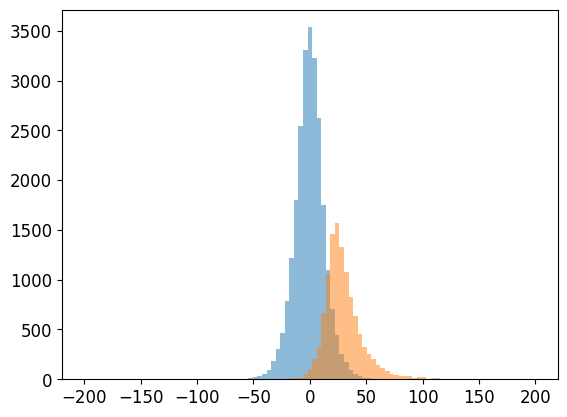

In [197]:
bins = np.linspace(-200, 200, 100)
# plt.hist(e_miss - p_miss, bins=bins)
plt.hist(e_miss_mu - p_miss_mu, bins=bins, alpha=.5)
plt.hist(e_miss_pi - p_miss_pi, bins=bins, alpha=.5)
# plt.xlim((-1, 50))
plt.show()

In [7]:
good_events, primary_particle_idx, primary_particle_in_primary_idx = find_good_events_in_decay(primary_pdgid, farich_pdgid)

Empty Farich: 4542
Mismatches:  0
Missing K:  15362
Missing Mu in Mu event:  6387
Missing Pi in Pi event:  0
Full bad events:  26291
Good Events: 23709
47418
23709
23709


In [9]:
# datadir = "data"
# sipm_eff, PDE_wvs = init_sipm_eff()
# for key in sipm_eff.keys():
#     sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38
# 
# x_grid = np.arange(
#     -3 * norm_r * np.sin(np.pi / 27),
#     3 * norm_r * np.sin(np.pi / 27),
#     SIPM_CELL_SIZE,
# )
# z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
# grid = (x_grid, z_grid, PDE_wvs)
# 
# decay_file = uproot.open(filepath)
# coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
#     decay_file, grid, good_events, primary_particle_idx, primary_particle_in_primary_idx
# )


In [21]:
idf = pd.DataFrame()
idf['W'] = [35.]
# idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [205.]  # 200
idf['n_mean'] = [1.04511]
# 
# idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]
mu_mass = 105.65
pi_mass = 139.57
ka_mass = 493.68

In [22]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
what_to_group = 'beta'
r_width = float(idf.pixel_size.iloc[0]) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False
useuse_decision_tree = True


calibration_func = pol # pol
param_calibration_func = pol2_pol2 # d3pol2
p0 = (0.9, -5, 340) # (.95, 0, 300) #(.01, 1e-3, 1e-4)
p0_c =  (1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)
num_of_calibration_params = 3 # 3
num_of_param_fit_params = 3 # for param fit both prev and this number are important, cal_func as well, therefore p0 and p0_C
target_variable = 'beta'
target_angle = 'theta_p'
num_of_theta_intervals = 11 # 11


# sample_size = 12
cal_arr = False
errs = False

beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []


r_bins = np.arange(16, 80, step=3.3)
r_bins = np.array([[r_bins[i], r_bins[i + 2]] for i in range(len(r_bins) - 2)])
t_bins = np.arange(0, 7, step=0.25)
t_bins = np.array([[t_bins[i], t_bins[i + 1]] for i in range(len(t_bins) - 1)])

background_means_dict = {'1e6': 0.012, '1e5': 0.0015}
background_stds_dict = {'1e6': 0.0175, '1e5': 0.0055}

background_mean = background_means_dict['1e5']
background_std = background_stds_dict['1e5']

batch_size = 10000
num_of_classes = 4

In [23]:
dcr = '0'
print(dcr)
timer_start = perf_counter()
edf_d = edf_conc.copy()
gdf_d = gdf_conc.copy()
bdf_d = pd.DataFrame()
edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
edf_d = applySpaceCut(edf_d)
planeRecalculation(edf_d, idf)
planeRotation(edf_d)
edf_d = applySecondSpaceCut(edf_d)
edf_to_bdf(edf_d.mass, bdf_d)
edf_to_bdf(edf_d.true_p, bdf_d)
bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
edf_to_bdf(edf_d.beta, bdf_d)
recoAngles(edf_d, idf)
primaryDirectionRecalculation(edf_d)

recoAngles(edf_d, idf, rotation_mode=True)

calculateSignalCounts(edf_d, bdf_d)

cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                           step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                           calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                           target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
    
print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))

0


NameError: name 'edf_conc' is not defined

In [29]:
for dcr in  ['1e6'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.random.permutation(gdf_conc.index.shape[0])
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf_conc.loc[sample_ind]
        gdf_d = gdf_conc.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf_d = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        edf_slice = edf_d.loc[(sample_ind_2)]
        edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
    
    
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        edf_to_bdf(edf_d.mass, bdf_d)
        edf_to_bdf(edf_d.true_p, bdf_d)
        bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf_d)
        recoAngles(edf_d, idf)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles(edf_d, idf, rotation_mode=True)
        
        calculateSignalCounts(edf_d, bdf_d)
        edf_d = enforce_float32(edf_d)
        cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf_d['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf_d
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf_d], ignore_index=True)
        print(f'    Time elapsed on current sample ({sample}/{max_iter}): ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf_d = c_bdf_d

1e6
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (0/56):  213
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (1/56):  196
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (2/56):  204
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (3/56):  205
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (4/56):  212
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (5/56):  194
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
    Time elapsed on current sample (6/56):  192
    Generate noise with DCR per mm^2 1000000

In [32]:
bdf_d

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance
0,NaN,653.577759,0.987185,0,10.0,0.572920,0.840322,42.261030,0.973902,-0.013283,-1.345568,19.619853
1,493.679993,2484.930176,0.980831,32,10.0,0.104736,0.994520,39.953684,0.980328,-0.000503,-0.051289,136.948542
2,105.650002,2018.161011,0.998633,46,10.0,0.375733,0.930239,58.161409,0.998436,-0.000196,-0.019667,67.638987
3,NaN,470.602173,0.975714,0,10.0,0.442587,0.903647,29.825276,0.966901,-0.008813,-0.903220,15.817377
4,105.650002,507.325806,0.978997,19,10.0,0.226330,0.974497,44.388707,0.984258,0.005261,0.537369,39.512433
...,...,...,...,...,...,...,...,...,...,...,...,...
551511,NaN,816.706238,0.991736,0,10.0,0.144804,0.989534,22.394661,0.963311,-0.028425,-2.866213,15.817377
551512,139.570007,2499.760498,0.998445,49,10.0,0.448672,0.901024,59.154112,0.997898,-0.000547,-0.054749,110.805905
551513,139.570007,378.152161,0.938141,1,9.0,0.250940,0.968679,19.634244,0.960908,0.022767,2.426815,11.662821
551514,NaN,1056.493286,0.995037,0,10.0,0.369180,0.932624,24.107408,0.963980,-0.031057,-3.121238,15.817377


In [31]:
# pd.to_pickle(bdf_d, os.path.join('data', 'pickled_bdf_1e6_600000_field.pkl'))

In [12]:
bdf_d = pd.read_pickle(os.path.join('data', 'pickled_bdf_1e5_600000_field.pkl'))

In [28]:
bdf_d.distance = (bdf_d.distance * background_stds_dict['1e5'] + background_means_dict['1e5'] - background_means_dict['1e6']) / background_stds_dict['1e6']  

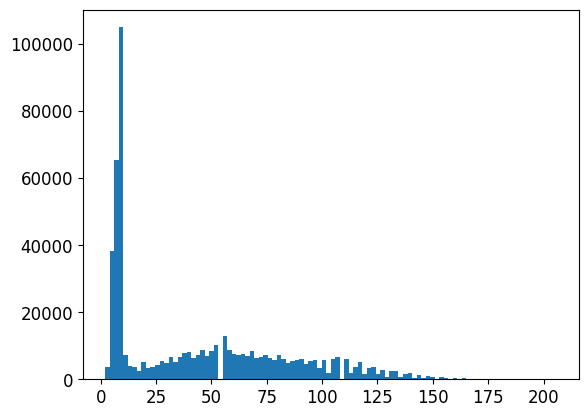

In [45]:
plt.hist(bdf_d.distance, bins=100)
plt.show()

In [31]:
Ы

NameError: name 'Ы' is not defined

In [46]:
bdf_d = bdf_d.dropna()

In [48]:
# Assuming `bdf_d` is your pandas DataFrame
# Step 1: Extract features and target
X = bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]
y = bdf_d['mass']

# Step 2: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # mass: [139.57 -> 0, 105.65 -> 1]
# 
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# y_train[X_train.signal_counts <= 1] = 0
# y_train[(y_train == mu_mass) & (X_train.momentum < 350)] = 0
# y_train[(y_train == pi_mass) & (X_train.momentum < 500)] = 0
# y_train[(y_train == ka_mass) & (X_train.momentum < 1800)] = 0

In [ ]:
from sklearn.model_selection import GridSearchCV

In [49]:
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=3,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    use_label_encoder=False,
    learning_rate=0.1,     
    n_estimators=600,      # Подбираем снова
    max_depth=5,           # Подобрали выше
    min_child_weight=1,    # Подобрали выше
    gamma=0.6,             # Подобрали выше
    subsample=0.9,         # Подобрали выше
    colsample_bytree=0.75, # Подобрали выше
    reg_alpha=1e-5,        # Подобрали выше
    seed=42,
    n_jobs=-1  
)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Map back predictions to mass values if needed
y_pred_mass = label_encoder.inverse_transform(y_pred)

X_test['mass'] = label_encoder.inverse_transform(y_test)
X_test['mass_reco'] = y_pred_mass

Accuracy: 0.8592566602947226
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83     29494
           1       0.79      0.80      0.80     28058
           2       0.98      0.95      0.97     25102

    accuracy                           0.86     82654
   macro avg       0.87      0.86      0.86     82654
weighted avg       0.86      0.86      0.86     82654



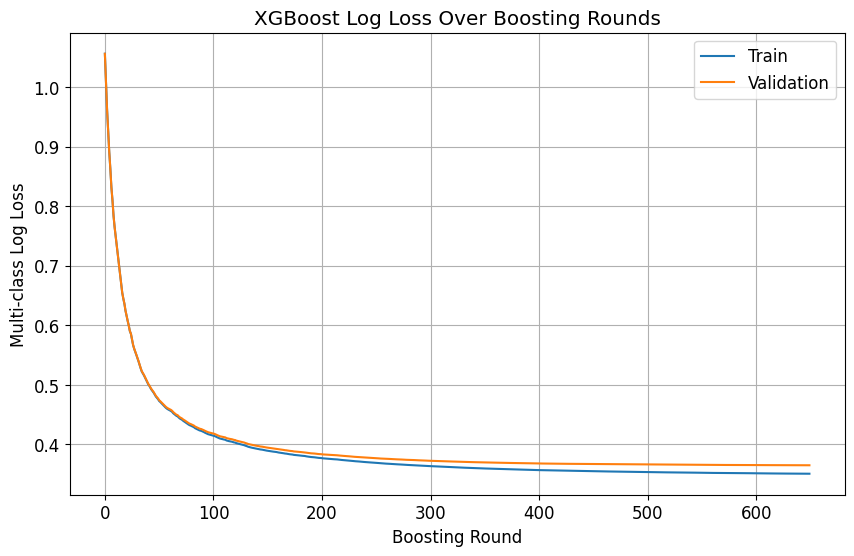

In [30]:
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']],
    y_train,
    test_size=0.2,
    random_state=42
)

# Объявляем модель
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    learning_rate=0.1,
    n_estimators=650,
    max_depth=5,
    min_child_weight=1,
    gamma=0.6,
    subsample=0.9,
    colsample_bytree=0.75,
    reg_alpha=1e-5,
    seed=42,
    n_jobs=-1
)

# Обучаем с валидацией
model.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_train_fit, y_train_fit), (X_val, y_val)],
    verbose=False  # Можно True, если хочешь видеть лог
)

# Строим график logloss
results = model.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('Multi-class Log Loss')
plt.title('XGBoost Log Loss Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
intervals = np.arange(300, 2200, 300)
intervals[-1] = 2500

In [53]:
intervals

array([ 300,  600,  900, 1200, 1500, 1800, 2500])

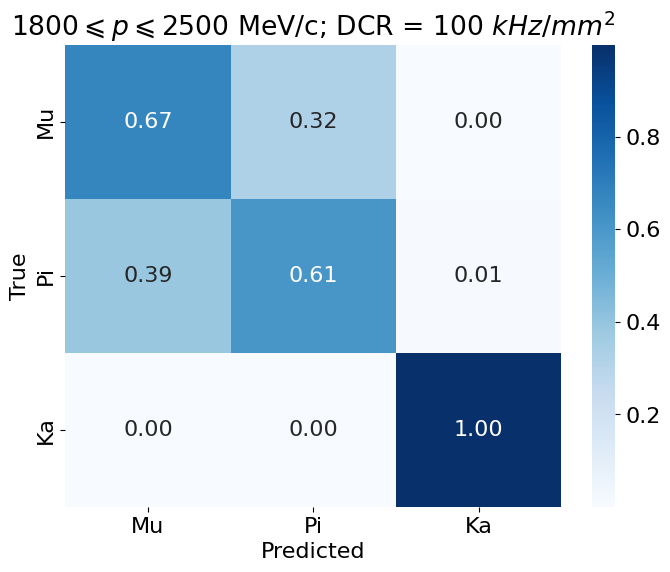

In [128]:
chosen_interval = 5
X_to_plot = X_test[(X_test.momentum > intervals[chosen_interval]) & (X_test.momentum < intervals[chosen_interval + 1])]
cm = confusion_matrix(label_encoder.transform(X_to_plot.mass), model.predict(X_to_plot[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
# plt.title(r'$\leq$')
plt.title(f'{intervals[chosen_interval]}$\leqslant p\leqslant${ intervals[chosen_interval + 1]} MeV/c; DCR = 100 $kHz$/$mm^2$')
plt.show()

In [50]:
X_test[['mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d[['mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d['mass_reco'] = label_encoder.inverse_transform(model.predict(X))

In [ ]:
    shift_ind = np.array(edf_mu.index.get_level_values(0))[-1] + 1
    new_index = edf_pi.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_pi.index = pd.MultiIndex.from_tuples(new_index, names=edf_mu.index.names)
    gdf_pi.index = np.array(gdf_pi.index) + np.array(gdf_mu.index)[-1] + 1

    shift_ind = np.array(edf_pi.index.get_level_values(0))[-1] + 1
    new_index = edf_ka.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_ka.index = pd.MultiIndex.from_tuples(new_index, names=edf_pi.index.names)
    gdf_ka.index = np.array(gdf_ka.index) + np.array(gdf_pi.index)[-1] + 1


    edf_conc = pd.concat([edf_mu, edf_pi, edf_ka])
    gdf_conc = pd.concat([gdf_mu, gdf_pi, gdf_ka])
    
    edf_mu = gdf_mu = edf_ka = gdf_ka = edf_pi = gdf_pi = 0
    edf_conc = enforce_float32(edf_conc)

In [17]:
primary_pdgid[0]

array([    30443,       421,      -321,       -13,        14,      -421,
       480000000])

In [10]:
# edf_conc = pd.DataFrame()
# gdf_conc = pd.DataFrame()

for i in range(10):
    filepath = os.path.join("data", f"decay_Kmu_50000_field_bin_{i+1}.root")
    file = uproot.open(filepath)
    primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())
    farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())
    good_events, primary_particle_idx, primary_particle_in_primary_idx = find_good_events_in_decay(primary_pdgid, farich_pdgid)
    edf, bdf, gdf, main_angles_tmp = create_edf_decay(f"decay_Kmu_50000_field_bin_{i+1}.root", good_events, primary_particle_idx, primary_particle_in_primary_idx)

    if i > 0:
        shift_ind = np.array(edf_conc.index.get_level_values(0))[-1] + 1
        new_index = edf.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
        edf.index = pd.MultiIndex.from_tuples(new_index, names=edf_conc.index.names)
        gdf.index = np.array(gdf.index) + np.array(gdf_conc.index)[-1] + 1
        edf_conc = pd.concat([edf_conc, edf])
        gdf_conc = pd.concat([gdf_conc, gdf])
        edf_conc = enforce_float32(edf_conc)
    else:
        edf_conc = edf.copy()
        gdf_conc = gdf.copy()

Empty Farich: 4542
Mismatches:  0
Missing K:  15362
Missing Mu in Mu event:  6387
Missing Pi in Pi event:  0
Full bad events:  26291
Good Events: 23709
47418
23709
23709
(47418, 5)
(47418, 3)
Empty Farich: 4445
Mismatches:  0
Missing K:  15487
Missing Mu in Mu event:  6458
Missing Pi in Pi event:  0
Full bad events:  26390
Good Events: 23610
47220
23610
23610
(47220, 5)
(47220, 3)
Empty Farich: 4434
Mismatches:  0
Missing K:  15476
Missing Mu in Mu event:  6474
Missing Pi in Pi event:  0
Full bad events:  26384
Good Events: 23616
47232
23616
23616
(47232, 5)
(47232, 3)
Empty Farich: 4558
Mismatches:  0
Missing K:  15412
Missing Mu in Mu event:  6433
Missing Pi in Pi event:  0
Full bad events:  26403
Good Events: 23597
47194
23597
23597
(47194, 5)
(47194, 3)
Empty Farich: 4512
Mismatches:  0
Missing K:  15399
Missing Mu in Mu event:  6401
Missing Pi in Pi event:  0
Full bad events:  26312
Good Events: 23688
47376
23688
23688
(47376, 5)
(47376, 3)
Empty Farich: 4479
Mismatches:  0
Missin

In [15]:
gdf_conc.shape[0] / 2

235936.0

In [25]:
batch_size=10000

In [26]:
for dcr in  ['1e6'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.array(sorted(np.random.permutation(gdf_conc.index.shape[0])))
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    print(max_iter)
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf_conc.loc[sample_ind]
        gdf_d = gdf_conc.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        # sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        # edf_slice = edf_d.loc[(sample_ind_2)]
        # edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
        # 
        edf_to_bdf(edf_d.mass, bdf)
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        
        print(np.unique(bdf.mass, return_counts=True))
        edf_to_bdf(edf_d.true_p, bdf)
        bdf.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf)
        recoAngles(edf_d, idf, for_decay=True)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles(edf_d, idf, rotation_mode=True, for_decay=True)
        
        calculateSignalCounts(edf_d, bdf)
        edf_d = enforce_float32(edf_d)
        rSlidingWindow(edf_d, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf], ignore_index=True)
        print('    Time elapsed on current sample: ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf = c_bdf_d

1e6
48
    Generate noise with DCR 1e+06 Hz/mm², mean hits/event ≈ 1750.00
(array([105.65, 493.68], dtype=float32), array([5000, 5000], dtype=int64))
    Time elapsed on current sample:  29
    Generate noise with DCR 1e+06 Hz/mm², mean hits/event ≈ 1750.00
(array([105.65, 493.68], dtype=float32), array([5000, 5000], dtype=int64))
    Time elapsed on current sample:  28
    Generate noise with DCR 1e+06 Hz/mm², mean hits/event ≈ 1750.00
(array([105.65, 493.68], dtype=float32), array([5000, 5000], dtype=int64))
    Time elapsed on current sample:  28
    Generate noise with DCR 1e+06 Hz/mm², mean hits/event ≈ 1750.00
(array([105.65, 493.68], dtype=float32), array([5000, 5000], dtype=int64))
    Time elapsed on current sample:  28
    Generate noise with DCR 1e+06 Hz/mm², mean hits/event ≈ 1750.00
(array([105.65, 493.68], dtype=float32), array([5000, 5000], dtype=int64))
    Time elapsed on current sample:  27
    Generate noise with DCR 1e+06 Hz/mm², mean hits/event ≈ 1750.00
(array([10

In [27]:
bdf

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,distance
0,493.679993,809.394653,0.853727,0,8.0,0.645432,0.798840,28.691212,20.787294
1,105.650002,366.857361,0.960945,2,10.0,0.887650,0.631237,27.995552,20.787294
2,493.679993,628.809631,0.786552,0,7.0,0.778906,0.711682,31.642694,22.104895
3,105.650002,470.309570,0.975685,27,10.0,0.420022,0.913080,44.971752,63.383529
4,493.679993,710.910706,0.821374,0,8.0,0.850222,0.659816,22.097578,18.568535
...,...,...,...,...,...,...,...,...,...
471666,105.650002,343.018402,0.955696,1,10.0,0.894869,0.625621,16.204096,27.989166
471667,493.679993,839.236023,0.861929,0,8.0,0.198049,0.980452,20.786022,18.407223
471668,105.650002,359.810730,0.959493,2,10.0,0.060342,0.998180,16.916420,18.568535
471669,493.679993,492.427277,0.706208,0,6.0,0.425522,0.910823,26.362562,18.568535


In [32]:
bdf.distance = (bdf.distance * background_stds_dict['1e5'] + background_means_dict['1e5'] - background_means_dict['1e6']) / background_stds_dict['1e6']  

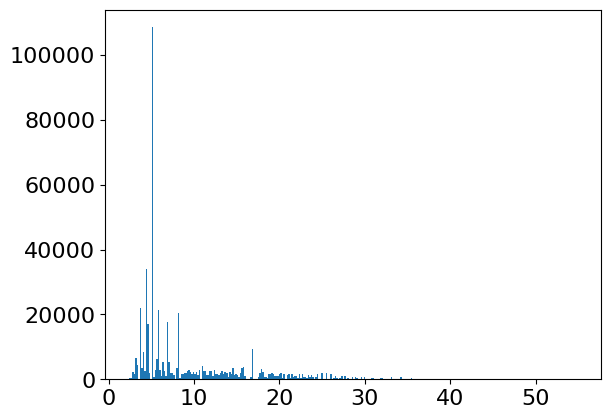

In [33]:
plt.hist(bdf.distance, bins='auto')
plt.show()

In [34]:
pd.to_pickle(bdf, os.path.join('data', 'pickled_bdf_1e6_decay_field_kmu_500000.pkl'))

In [13]:
bdf = pd.read_pickle(os.path.join('data', 'pickled_bdf_1e5_decay_field.pkl'))

In [63]:
np.unique(bdf.mass, return_counts=True)

(array([105.65, 139.57, 493.68], dtype=float32),
 array([13393,  4600, 17993], dtype=int64))

In [55]:
bdf[['mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])


In [56]:
bdf['mass_reco'] = label_encoder.inverse_transform(model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))

In [104]:
theta_p = bdf.theta_p.values
momentum = bdf.momentum.values
mass = np.round(bdf.mass.values)
mass_reco = np.round(bdf.mass_reco.values)
mu_proba = bdf.mu_proba.values
pi_proba = bdf.pi_proba.values
total = mu_proba + pi_proba
# Avoid division by zero
total[total == 0] = 1

mu_proba = mu_proba / total
pi_proba = pi_proba / total

# Предварительная фильтрация по условиям, которые не зависят от delim
mask = (theta_p[:-1] < 0.79) & (theta_p[1:] < 0.79) & (momentum[:-1] > 310) & (momentum[1:] > 310)
indices = np.where(mask)[0]

is_mu = mass[indices + 1] == round(mu_mass)
is_pi = mass[indices + 1] == round(pi_mass)
is_pi   .sum() 

3428

In [14]:
def calculate_eff_misid(bdf):
    theta_p = bdf.theta_p.values
    momentum = bdf.momentum.values
    mass = np.round(bdf.mass.values)
    mass_reco = np.round(bdf.mass_reco.values)
    mu_proba = bdf.mu_proba.values
    pi_proba = bdf.pi_proba.values
    total = mu_proba + pi_proba
# Avoid division by zero
    total[total == 0] = 1
    
    mu_proba = mu_proba / total
    pi_proba = pi_proba / total
    
    # Предварительная фильтрация по условиям, которые не зависят от delim
    mask = (theta_p[:-1] < 0.79) & (theta_p[1:] < 0.79) & (momentum[:-1] > 310) & (momentum[1:] > 310)
    indices = np.where(mask)[0]
    
    # Предварительно посчитаем маски
    is_mu = mass[indices + 1] == round(mu_mass)
    is_pi = mass[indices + 1] == round(pi_mass)
    is_ka_reco = mass_reco[indices] == round(ka_mass)
    
    # Массивы вероятностей
    mu_probs = mu_proba[indices + 1]
    pi_probs = pi_proba[indices + 1]
    
    # Подсчеты
    effs = []
    misids = []
    
    delims = np.linspace(0.001, 0.99, 100)
    
    for delim in delims:
        mu_mask = is_mu
        mu_pass = is_ka_reco & mu_mask & (mu_probs > 1 - delim)
        kamu_gen = np.sum(mu_mask)
        kamu_reco = np.sum(mu_pass)
    
        pi_mask = is_pi
        pi_fail = is_ka_reco & pi_mask & (pi_probs < delim)
        kapi_gen = np.sum(pi_mask)
        kamu_misreco = np.sum(pi_fail)
    
        effs.append(kamu_reco / kamu_gen if kamu_gen > 0 else 0)
        misids.append(kamu_misreco / kapi_gen if kapi_gen > 0 else 0)
    
    return np.array(effs), np.array(misids)

In [15]:
def split_dataframe(df, n_parts, seed=None):
    if seed is not None:
        np.random.seed(seed)

    indices = np.random.permutation(int(df.shape[0] / 2))
    split_indices = np.array_split(indices, n_parts)
    split_indices = [sorted(np.concatenate((split_ind * 2, split_ind * 2 + 1))) for split_ind in split_indices]
    return [df.loc[idx].copy() for idx in split_indices]

In [110]:
num_of_splits = 4
effs_arr = np.zeros((2, num_of_splits, 100))
misids_arr = np.zeros((2, num_of_splits, 100))

for j in range(2):
    bdf = pd.read_pickle(os.path.join('data', f'pickled_bdf_1e{5+j}_decay_field.pkl'))
    odd_rows = bdf.loc[1::2]
    mask = odd_rows.mass == mu_mass
    filtered = odd_rows[mask]
    
    # id_to_drop = np.array(filtered.sample(frac=0.9).index)
    # id_to_drop = np.concatenate([id_to_drop - 1, id_to_drop])
    
    # bdf.drop(id_to_drop, axis=0, inplace=True)
    if j == 0:
        effs, misids = calculate_eff_misid(bdf)
    elif j == 1:
        effs_2, misids_2 = calculate_eff_misid(bdf)
    split_bdf = split_dataframe(bdf, num_of_splits, 42)

    for i in range(num_of_splits):
        e_m = calculate_eff_misid(split_bdf[i])
        effs_arr[j, i, :] = e_m[0]
        misids_arr[j, i, :] = e_m[1]


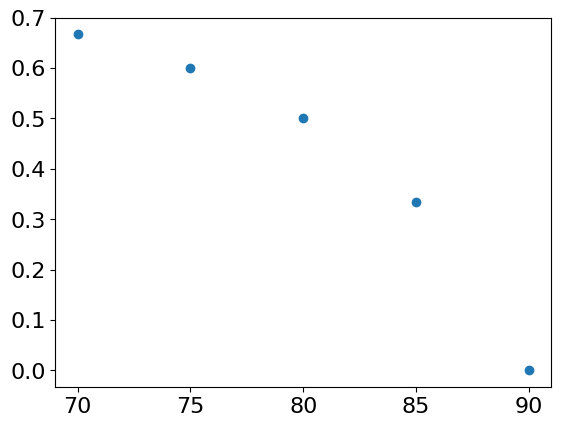

In [124]:
plt.scatter(pi_calo_effs := np.array([90, 85, 80, 75, 70]), 1. - 0.1 / (1. - pi_calo_effs/100))
plt.show()

In [132]:
bdf = pd.read_pickle(os.path.join('data', f'pickled_bdf_1e{5+j}_decay_field.pkl'))
odd_rows = bdf.loc[1::2]
mask = odd_rows.mass == mu_mass
filtered = odd_rows[mask]
mask = odd_rows.mass == pi_mass
filtered_2 = odd_rows[mask]
print((filtered.shape[0]))

13393


In [154]:
bdf.shape[0]

35986

In [147]:
91./5

18.2

In [150]:
1 -.09 / ( .09 + .91 * (1 - np.linspace(80, 95, 16) / 100))

array([0.66911765, 0.65766451, 0.64539007, 0.6322027 , 0.6179966 ,
       0.60264901, 0.58601656, 0.56793087, 0.54819277, 0.52656497,
       0.50276243, 0.47643979, 0.44717445, 0.41444372, 0.37759336,
       0.33579336])

In [151]:
pi_calo_effs = np.linspace(80, 95, 16)
num_of_splits = len(pi_calo_effs)
effs_arr = np.zeros((2, num_of_splits, 100))
misids_arr = np.zeros((2, num_of_splits, 100))

for j in range(2):
    bdf = pd.read_pickle(os.path.join('data', f'pickled_bdf_1e{5+j}_decay_field.pkl'))
    odd_rows = bdf.loc[1::2]
    mask = odd_rows.mass == mu_mass
    filtered = odd_rows[mask]
    mask_pi = odd_rows.mass == pi_mass
    filtered_pi = odd_rows[mask_pi]

    if j == 0:
        effs, misids = calculate_eff_misid(bdf)
    elif j == 1:
        effs_2, misids_2 = calculate_eff_misid(bdf)
    # split_bdf = split_dataframe(bdf, num_of_splits, 42)

    for i in range(num_of_splits):
        if pi_calo_effs[i] <= 100:
            frac = round(1 -.09 / ( .09 + .91 * (1 - pi_calo_effs[i] / 100)), 10)
            id_to_drop = np.array(filtered.sample(frac=frac).index)
            id_to_drop = np.concatenate([id_to_drop - 1, id_to_drop])
        else:
            frac = round(1 - (1 - pi_calo_effs[i] / 100) / 0.1, 10) 
            id_to_drop = np.array(filtered_pi.sample(frac=frac).index)
            id_to_drop = np.concatenate([id_to_drop - 1, id_to_drop])
        
            # print(frac)
        
        split_bdf = bdf.drop(id_to_drop, axis=0, inplace=False)
        e_m = calculate_eff_misid(split_bdf)
        effs_arr[j, i, :] = e_m[0]
        misids_arr[j, i, :] = e_m[1]


cross-val

In [163]:
split_bdf[0]

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,mu_proba,pi_proba,ka_proba,mass_reco
0,493.679993,754.237976,0.836703,1,8.0,0.095826,0.995412,26.816278,0.924726,0.088023,10.520213,4.371176,0.003264,0.012216,0.984520,493.679993
1,139.570007,284.533508,0.897805,1,9.0,0.486501,0.883974,51.981463,0.984727,0.086922,9.681658,5.480781,0.443743,0.349694,0.206563,105.650002
6,493.679993,720.657532,0.824988,0,8.0,0.416123,0.914663,25.544968,0.945690,0.120702,14.630750,5.185127,0.009370,0.011216,0.979414,493.679993
7,105.650002,489.018005,0.977449,25,10.0,0.422704,0.911983,42.060941,0.976145,-0.001303,-0.133345,11.818193,0.955777,0.043912,0.000312,105.650002
10,493.679993,913.501404,0.879749,0,9.0,0.824050,0.679254,19.649372,0.970368,0.090619,10.300587,8.196595,0.334723,0.139298,0.525978,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35969,105.650002,402.808594,0.967282,14,10.0,0.427500,0.910005,30.578613,0.965523,-0.001759,-0.181867,9.863736,0.973954,0.019758,0.006289,105.650002
35972,493.679993,376.573090,0.606487,0,4.0,0.567060,0.843484,25.085881,0.964463,0.357976,59.024475,5.933149,0.374214,0.403569,0.222217,139.570007
35973,139.570007,883.787598,0.987759,39,10.0,0.071696,0.997431,45.062831,0.986176,-0.001583,-0.160278,28.468805,0.010727,0.989255,0.000018,139.570007
35982,493.679993,699.972656,0.817198,0,8.0,0.197901,0.980481,22.471572,0.945018,0.127820,15.641205,5.235825,0.009638,0.015328,0.975033,493.679993


In [113]:
import csv
data = list(zip(effs_2, misids_2, effs, misids))

# Сохраняем в CSV
with open('eff-misid.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['eff1', 'misid1', 'eff2', 'misid2'])  # заголовки
    writer.writerows(data)

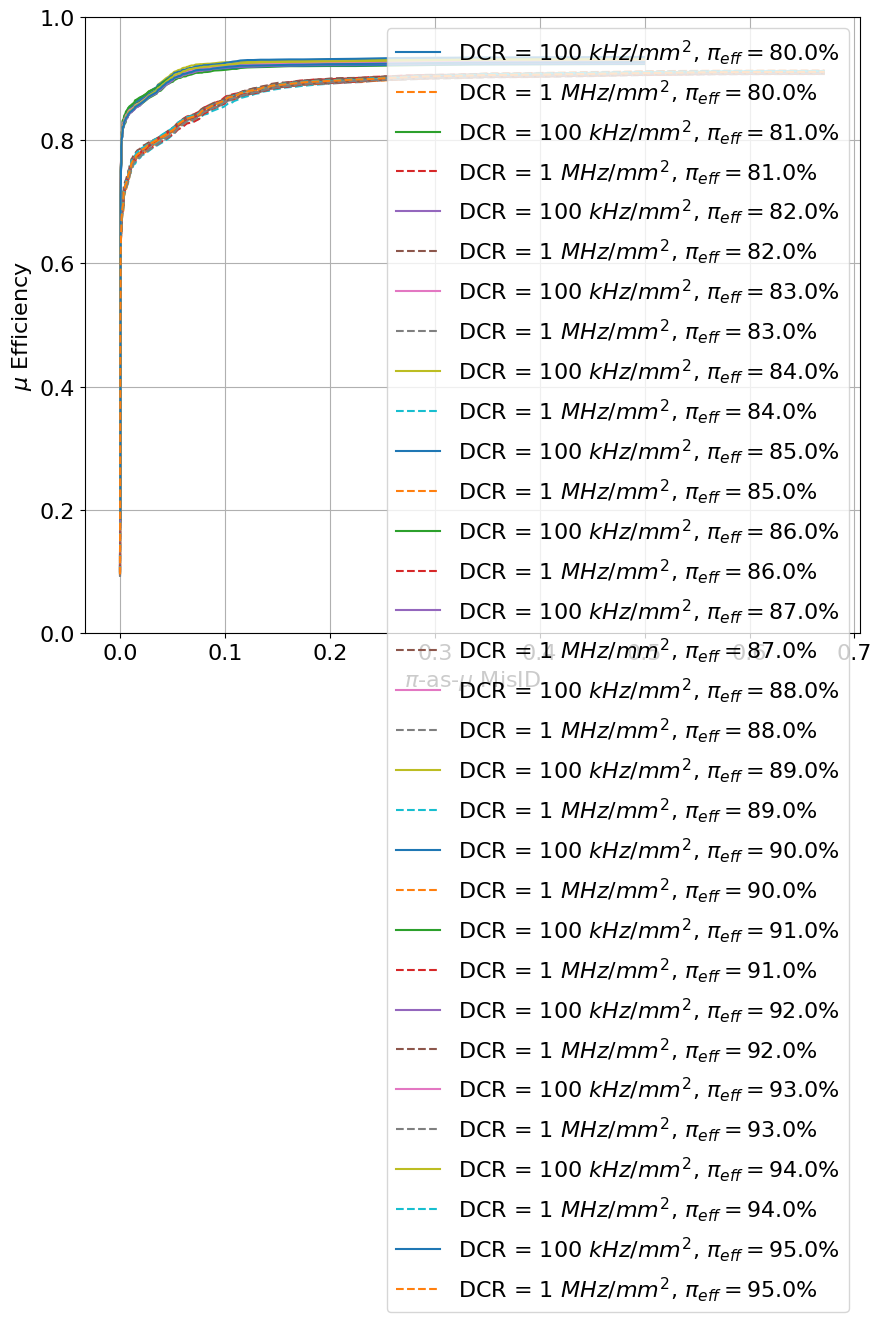

In [152]:
plt.figure(figsize=(10,8))
for i in range(num_of_splits):
    plt.plot(misids_arr[0, i], effs_arr[0, i], label='DCR = 100 $kHz/mm^2$, $\pi_{eff}=$'+f'{pi_calo_effs[i]}%')
    plt.plot(misids_arr[1, i], effs_arr[1, i], label='DCR = 1 $MHz/mm^2$, $\pi_{eff}=$'+f'{pi_calo_effs[i]}%', linestyle='--')
# plt.plot(misids_2, effs_2, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\mu$ Efficiency')
# plt.title('DCR = 100 $kHz/mm^2$')
plt.ylim((0, 1))
plt.legend()
# plt.xscale('log')
plt.grid()
plt.show()  

In [153]:
eff_error_for_1e5 = np.mean(np.abs((effs_arr[0, :,])), axis=0)
misid_error_for_1e5 = np.mean(np.abs((misids_arr[0, :,])), axis=0)

eff_error_for_1e5_rms = np.sqrt(np.mean((effs_arr[0, :,] - eff_error_for_1e5) ** 2, axis=0))
misid_error_for_1e5_rms = np.sqrt(np.mean((misids_arr[0, :,] - misid_error_for_1e5) ** 2, axis=0))

In [154]:
eff_error_for_1e6 = np.mean(np.abs((effs_arr[1, :,])), axis=0)
misid_error_for_1e6 = np.mean(np.abs((misids_arr[1, :,])), axis=0)

eff_error_for_1e6_rms = np.sqrt(np.mean((effs_arr[1, :,] - eff_error_for_1e6) ** 2, axis=0))
misid_error_for_1e6_rms = np.sqrt(np.mean((misids_arr[1, :,] - misid_error_for_1e6) ** 2, axis=0))

In [110]:
effs_err_1e5 = np.sqrt((1 - effs) * effs / bdf.shape[0] * 2)
misids_err_1e5 = np.sqrt((1 - misids) * misids / bdf.shape[0] * 2)

effs_err_1e6 = np.sqrt((1 - effs_2) * effs_2 / bdf.shape[0] * 2)
misids_err_1e6 = np.sqrt((1 - misids_2) * misids_2 / bdf.shape[0] * 2)

In [84]:
bdf.shape[0] / 2 / .44

40893.181818181816

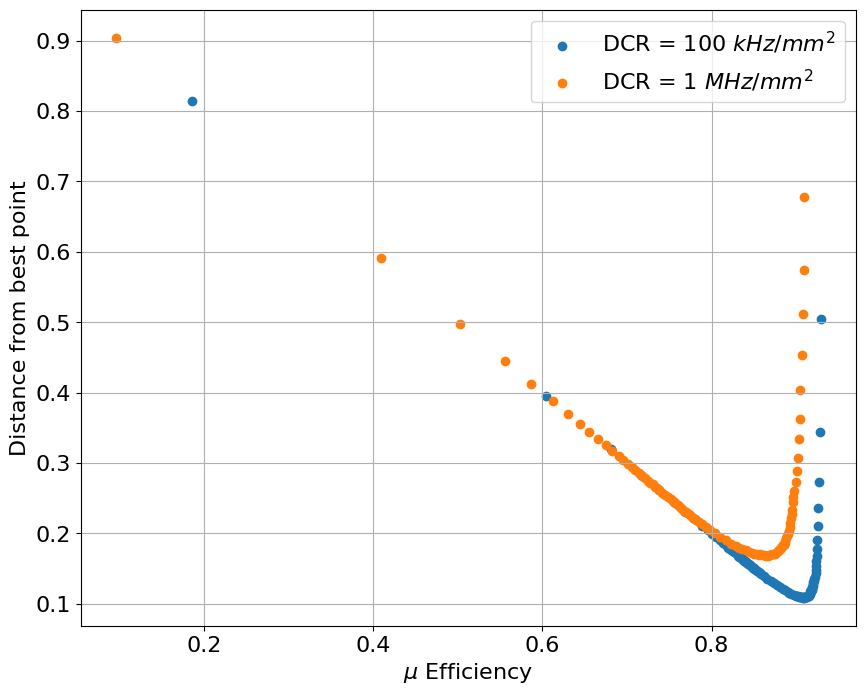

In [107]:
plt.figure(figsize=(10,8))
plt.scatter(effs, np.sqrt(misids ** 2 + (1 - effs) ** 2), label='DCR = 100 $kHz/mm^2$',)
plt.scatter(effs_2, np.sqrt(misids_2 ** 2 + (1 - effs_2) ** 2), label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('Distance from best point')
plt.legend()
plt.grid()
plt.show()

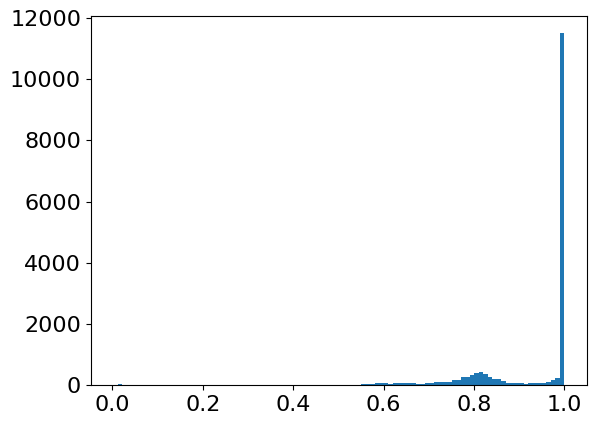

In [109]:
plt.hist(bdf.loc[1::2].mu_proba + bdf.loc[1::2].pi_proba, bins=100)
plt.show()

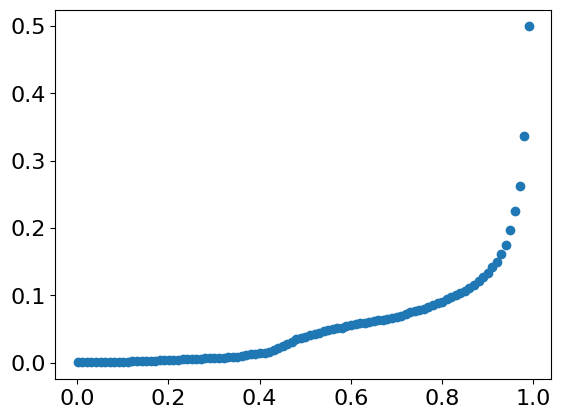

In [21]:
plt.scatter(np.linspace(0.001, 0.99, 100) , misids)
plt.show()

In [115]:
pis = 0
mus = 0
for primary_particles in primary_pdgid:
    if primary_particles[3] == 211:
        pis += 1
    if primary_particles[3] == -13:
        mus += 1

In [120]:
3.4/14.4

0.2361111111111111

In [131]:
pis

11290

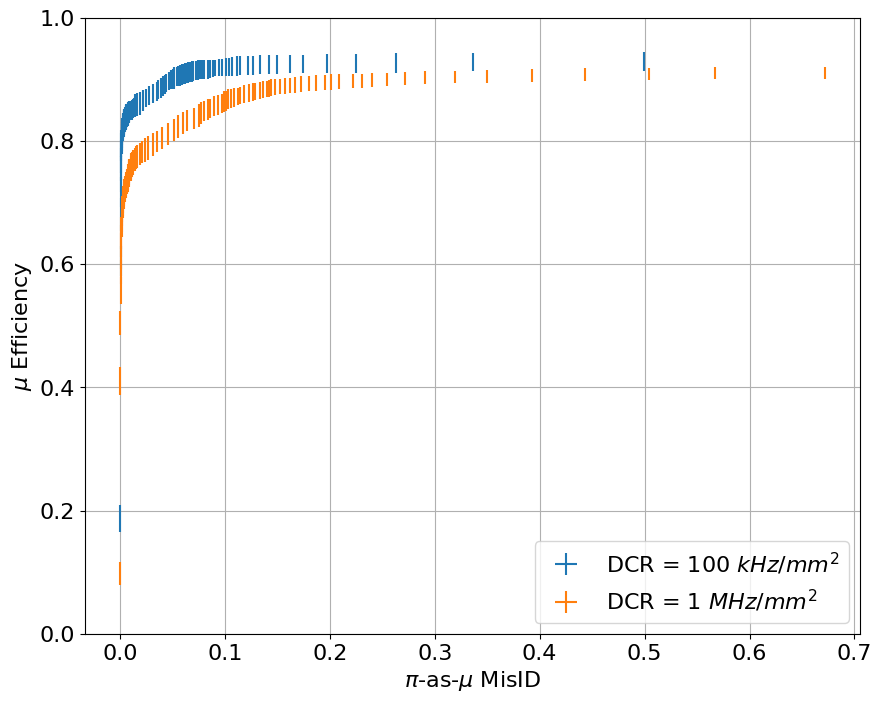

In [155]:
plt.figure(figsize=(10,8))

plt.errorbar(misid_error_for_1e5, eff_error_for_1e5, xerr=misid_error_for_1e5_rms*5, yerr=eff_error_for_1e5_rms*5, label='DCR = 100 $kHz/mm^2$', linestyle='None')
plt.errorbar(misid_error_for_1e6, eff_error_for_1e6, xerr=misid_error_for_1e6_rms*5, yerr=eff_error_for_1e6_rms*5, label='DCR = 1 $MHz/mm^2$', linestyle='None')
# plt.plot(misids, effs, label='DCR = 100 $kHz/mm^2$')
# plt.plot(misids_2, effs_2, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\mu$ Efficiency')
# plt.title('DCR = 100 $kHz/mm^2$')
plt.ylim((0, 1))
plt.legend()
# plt.xscale('log')
plt.grid()
plt.show()

In [72]:
misids_arr[0,:,13]

array([0.00204201, 0.00204201, 0.00204201, 0.00204201, 0.00204201,
       0.00204201, 0.00204201, 0.00204201, 0.00204201, 0.00204201,
       0.00204201, 0.00227347, 0.00181884, 0.00291667, 0.00244141,
       0.00174419])

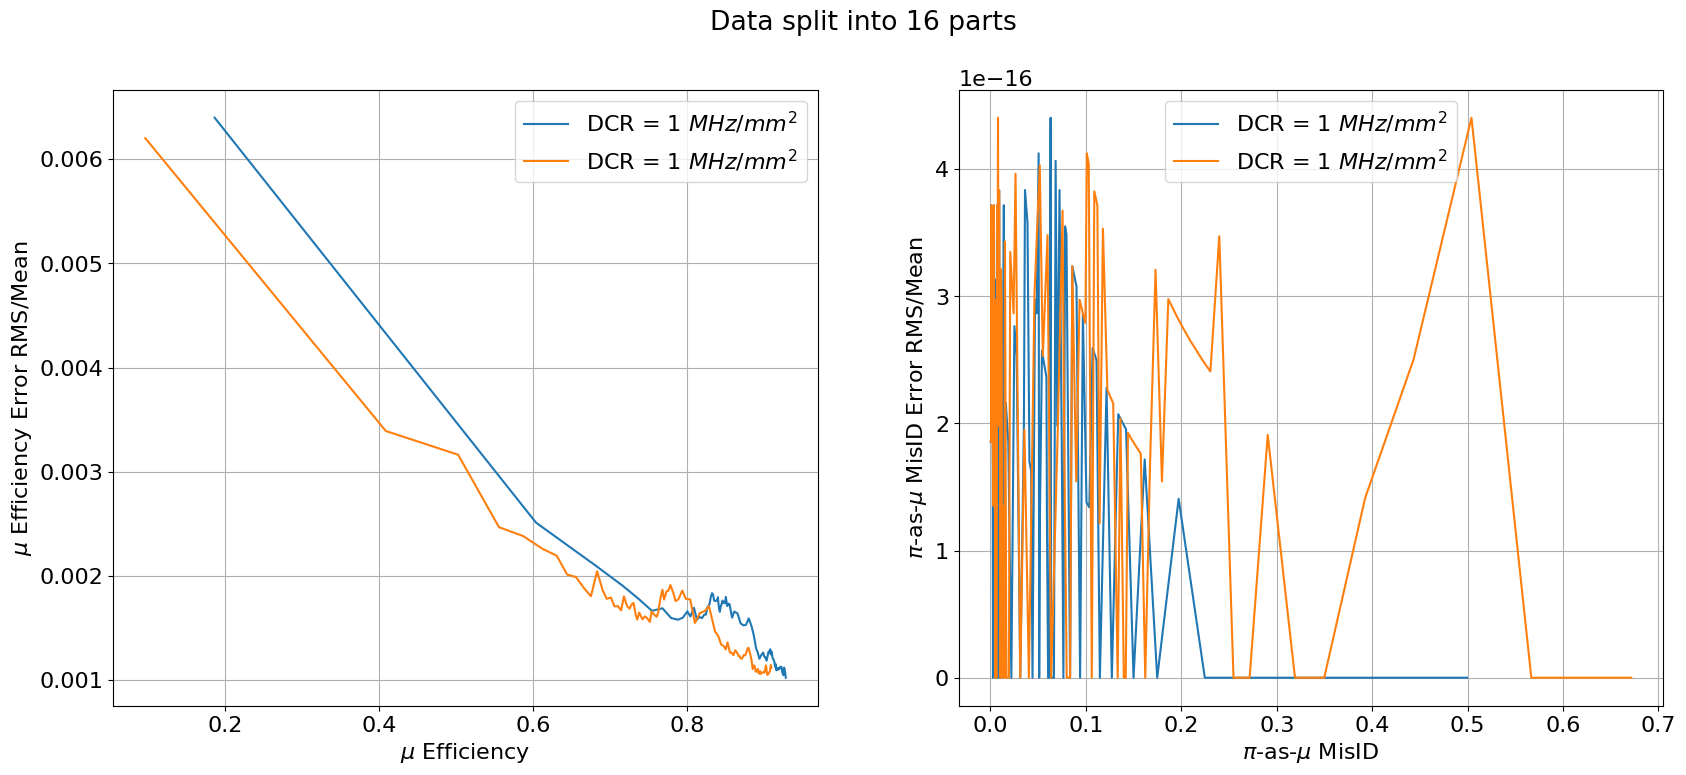

In [146]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(eff_error_for_1e5, eff_error_for_1e5_rms / eff_error_for_1e5, label='DCR = 1 $MHz/mm^2$')
plt.plot(eff_error_for_1e6, eff_error_for_1e6_rms / eff_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error RMS/Mean')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misid_error_for_1e5, misid_error_for_1e5_rms / misid_error_for_1e5, label='DCR = 1 $MHz/mm^2$')
plt.plot(misid_error_for_1e6, misid_error_for_1e6_rms / misid_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error RMS/Mean')
# plt.ylim((0.0, 0.2))
plt.suptitle(f'Data split into {num_of_splits} parts')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

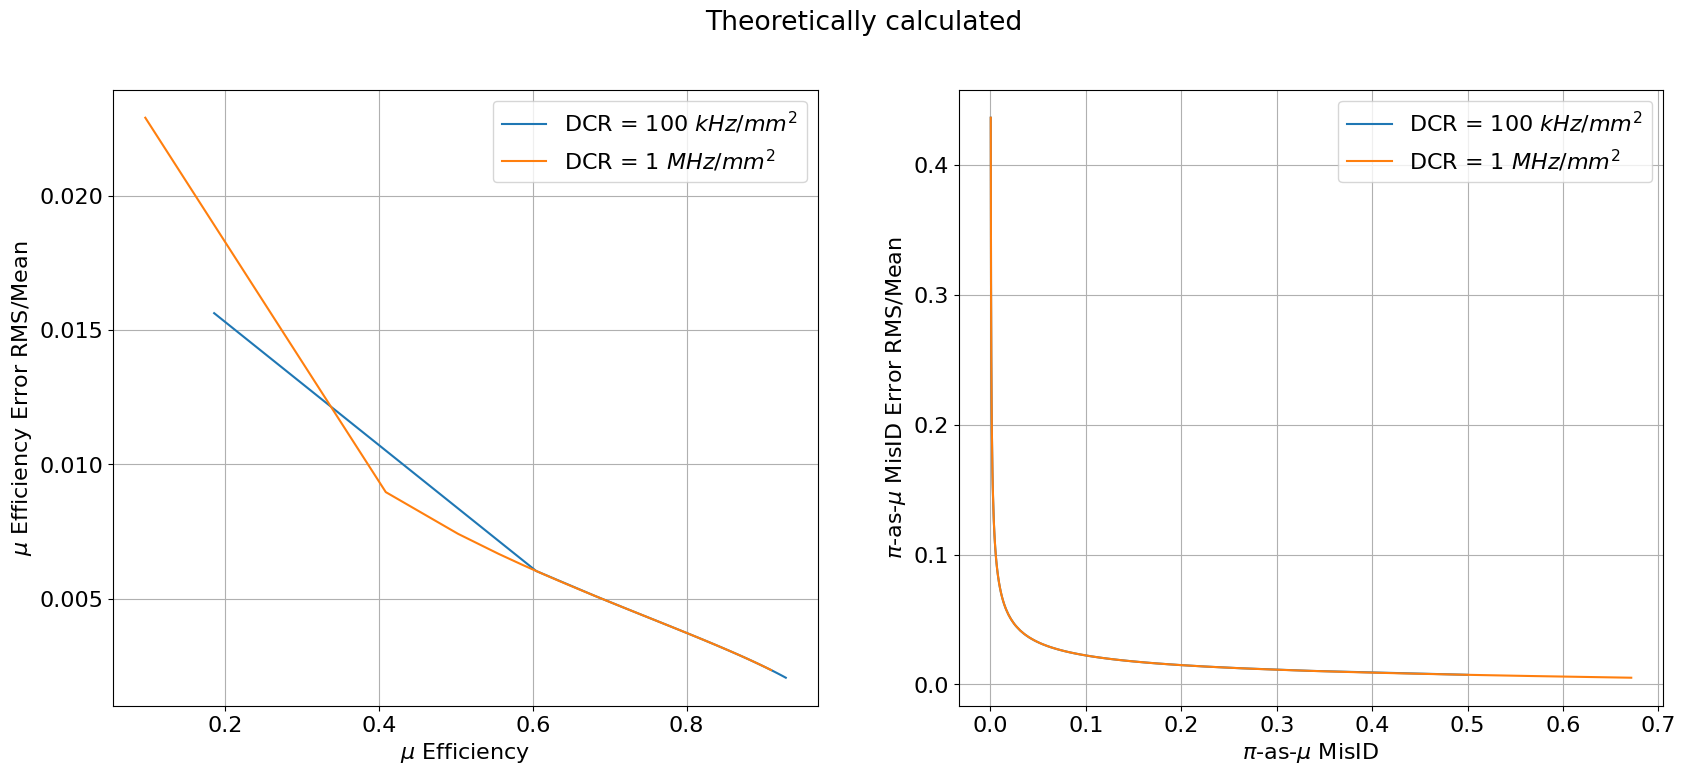

In [111]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(effs, effs_err_1e5 / effs, label='DCR = 100 $kHz/mm^2$')
plt.plot(effs_2, effs_err_1e6 / effs_2, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error RMS/Mean')
# plt.ylim((0.0, 0.004))
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misids, misids_err_1e5 / misids, label='DCR = 100 $kHz/mm^2$')
plt.plot(misids_2, misids_err_1e6 / misids_2, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error RMS/Mean')
# plt.ylim((0.0, 0.2))
plt.suptitle(f'Theoretically calculated')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

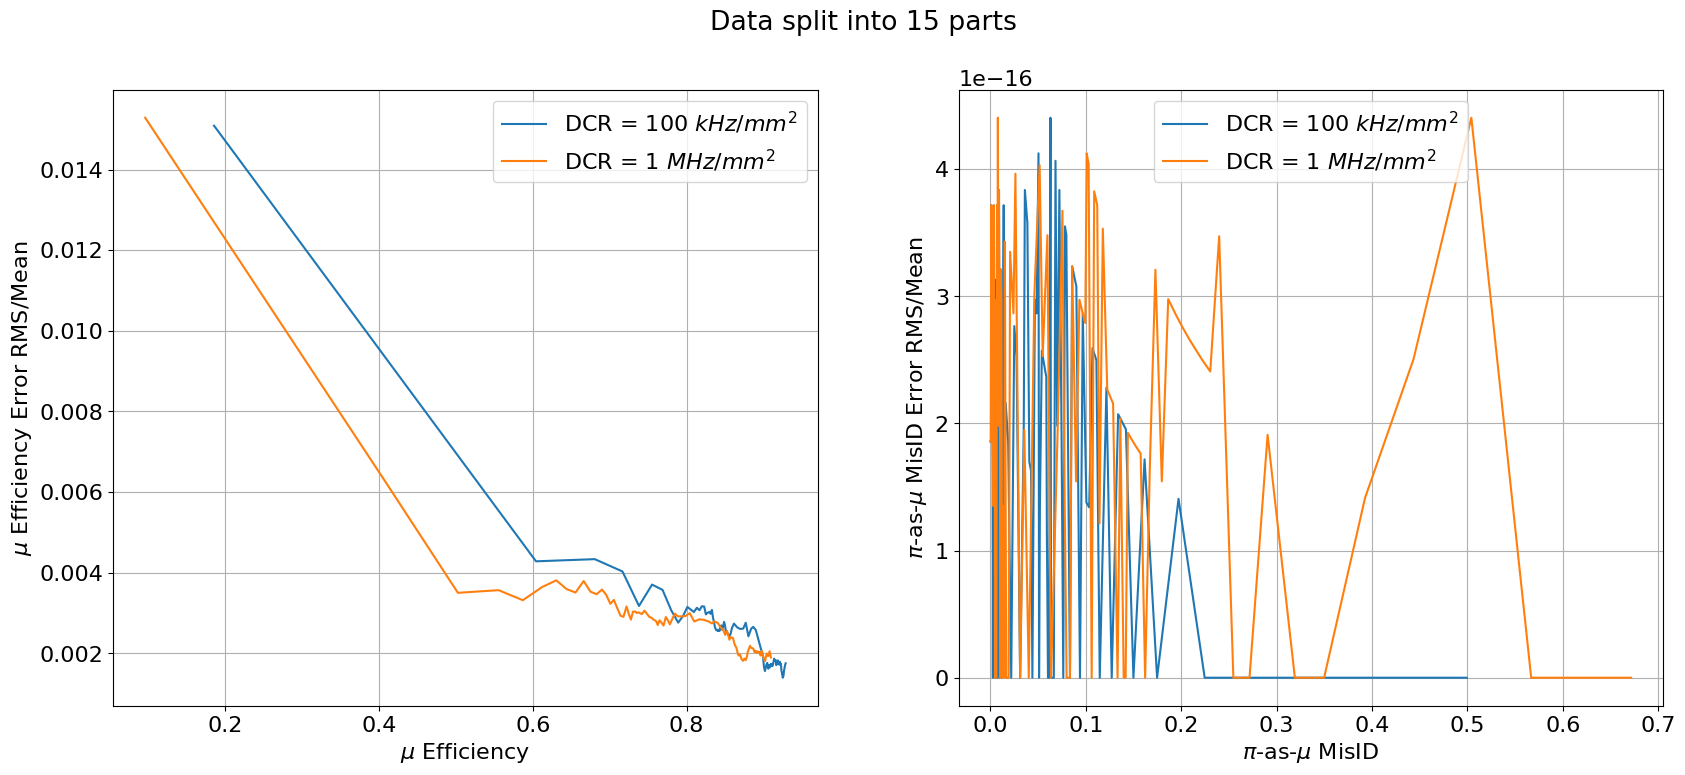

In [23]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(effs, eff_error_for_1e5_rms / effs, label='DCR = 100 $kHz/mm^2$')
plt.plot(effs_2, eff_error_for_1e6_rms / effs_2, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error RMS/Mean')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misids, misid_error_for_1e5_rms / misids, label='DCR = 100 $kHz/mm^2$')
plt.plot(misids_2, misid_error_for_1e6_rms / misids_2, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error RMS/Mean')
# plt.ylim((0.0, 0.2))
plt.suptitle(f'Data split into {num_of_splits} parts')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

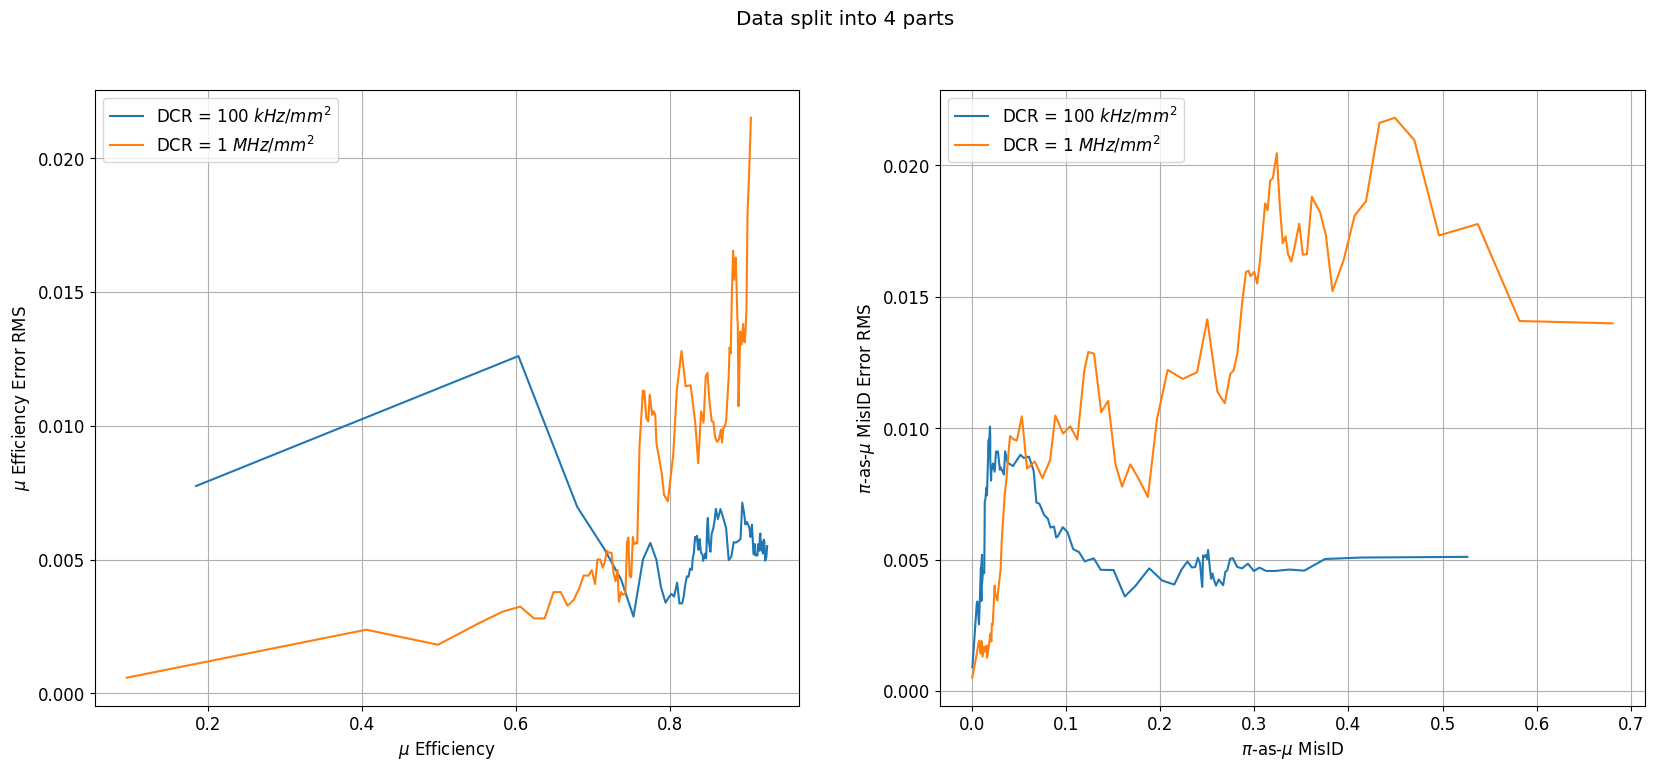

In [41]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(effs, eff_error_for_1e5_rms , label='DCR = 100 $kHz/mm^2$')
plt.plot(effs_2, misid_error_for_1e5_rms, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error RMS')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misids, eff_error_for_1e6_rms , label='DCR = 100 $kHz/mm^2$')
plt.plot(misids_2, misid_error_for_1e6_rms, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error RMS')
plt.suptitle(f'Data split into {num_of_splits} parts')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

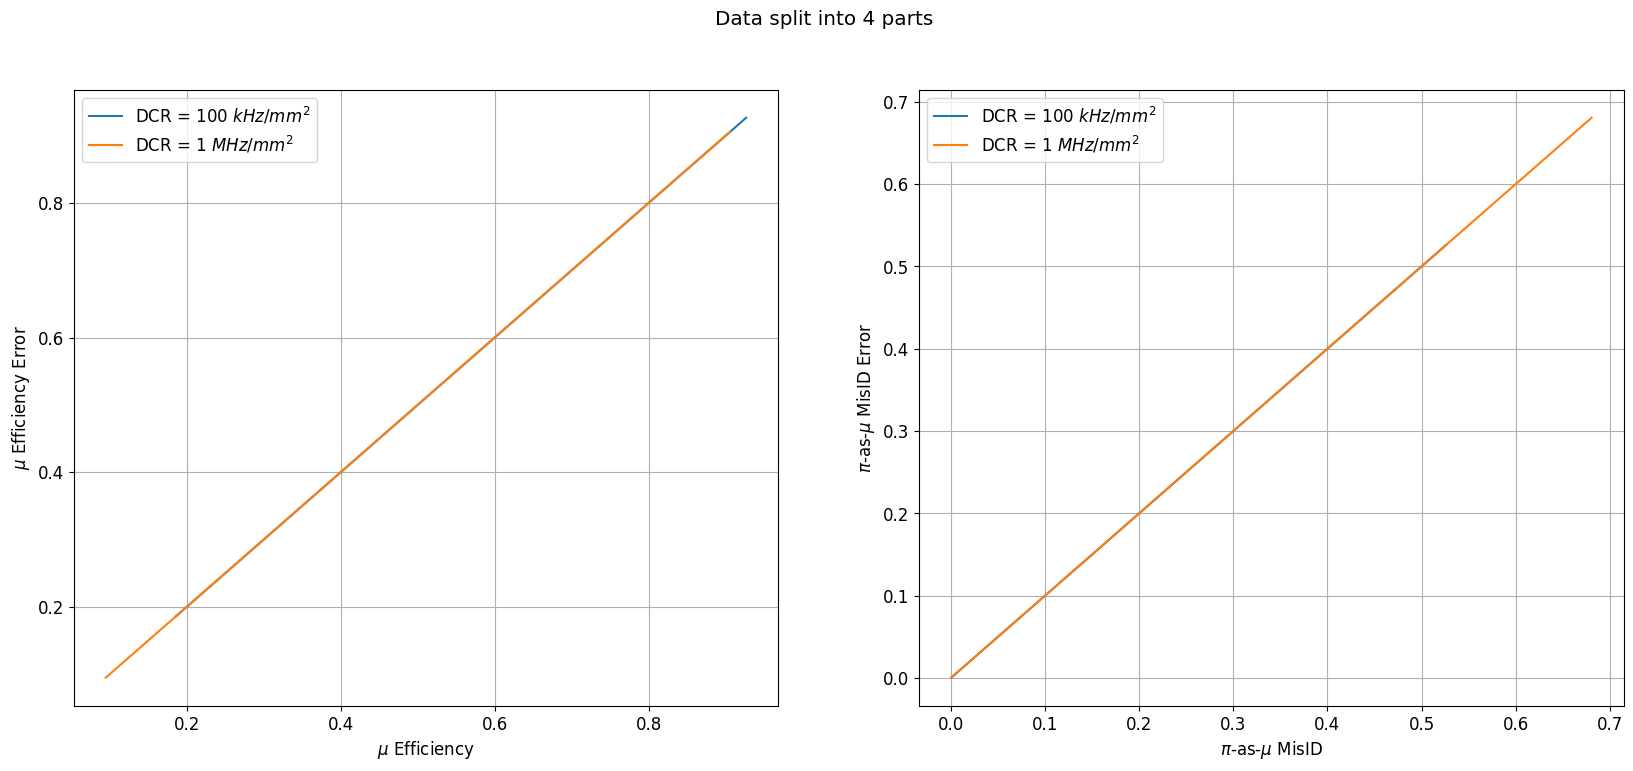

In [43]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(effs, eff_error_for_1e5, label='DCR = 100 $kHz/mm^2$')
plt.plot(effs_2, eff_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\mu$ Efficiency')
plt.ylabel('$\mu$ Efficiency Error')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(misids, misid_error_for_1e5, label='DCR = 100 $kHz/mm^2$')
plt.plot(misids_2, misid_error_for_1e6, label='DCR = 1 $MHz/mm^2$')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\pi$-as-$\mu$ MisID Error')
plt.suptitle(f'Data split into {num_of_splits} parts')
# plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.show()

In [77]:
bdf_d[(bdf_d.momentum > p_lims[0]) & (bdf_d.momentum < p_lims[1])].shape[0]

51098

In [107]:
p_lims = [300, 600, 900, 1200, 1500, 1800, 2500]
delims = np.linspace(0.001, 0.99, 100)
effs_for_ps = np.zeros((len(p_lims), 100))
misids_for_ps = np.zeros((len(p_lims), 100))
for i in range(len(delims)):
    for j in range(len(p_lims) - 1):
        mu_gen = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(mu_mass))].shape[0]
        pi_gen = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(pi_mass))].shape[0]
        mu_reco = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(mu_mass)) & (bdf_d.mu_proba > 1 - delims[i])].shape[0]
        misreco = bdf_d[(bdf_d.momentum > p_lims[j]) & (bdf_d.momentum < p_lims[j + 1]) & (round(bdf_d.mass) == round(pi_mass)) & (bdf_d.mu_proba > 1 - delims[i])].shape[0]
        effs_for_ps[j, i] = mu_reco / mu_gen
        misids_for_ps[j, i] = misreco / pi_gen
    

In [87]:
misids_for_ps

array([[2.17403120e-04, 2.71753900e-04, 3.26104680e-04, 3.80455460e-04,
        3.80455460e-04, 3.80455460e-04, 4.34806239e-04, 5.97858579e-04,
        7.60910919e-04, 7.60910919e-04, 9.78314039e-04, 9.78314039e-04,
        1.08701560e-03, 1.30441872e-03, 1.41312028e-03, 1.68487418e-03,
        1.90227730e-03, 2.17403120e-03, 2.60883744e-03, 2.71753900e-03,
        2.88059134e-03, 3.15234524e-03, 3.36974836e-03, 3.75020382e-03,
        4.18501005e-03, 4.29371161e-03, 4.45676395e-03, 5.00027175e-03,
        5.32637643e-03, 5.54377955e-03, 5.81553345e-03, 6.73949671e-03,
        7.17430295e-03, 7.50040763e-03, 8.09826621e-03, 8.31566933e-03,
        9.07658025e-03, 9.89184195e-03, 1.03809990e-02, 1.13049622e-02,
        1.22289255e-02, 1.33159411e-02, 1.42399043e-02, 1.47834121e-02,
        1.53812707e-02, 1.64139355e-02, 1.78270558e-02, 1.91314745e-02,
        2.13598565e-02, 2.39143432e-02, 2.72297407e-02, 3.08168922e-02,
        3.58171640e-02, 4.21218544e-02, 4.83721941e-02, 5.690526

In [74]:
plt.rcParams['font.size'] = 16

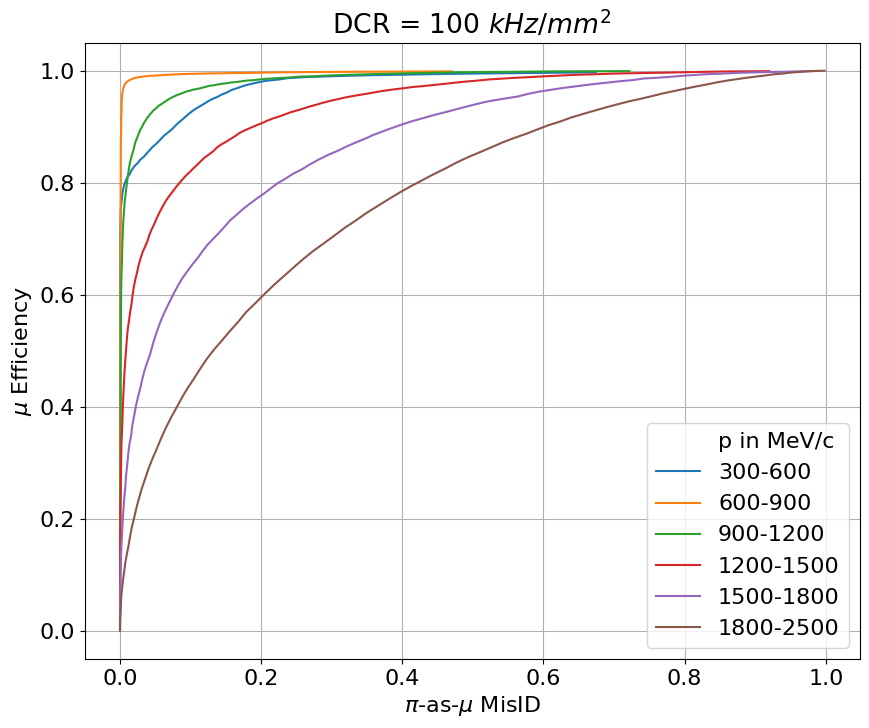

In [109]:
plt.figure(figsize=(10, 8))
plt.scatter(0.5, 0.5, color='white', label='p in MeV/c')
for i in range(len(p_lims)-1):
    plt.plot(misids_for_ps[i], effs_for_ps[i], label=f'{p_lims[i]}-{p_lims[i + 1]}')
plt.xlabel('$\pi$-as-$\mu$ MisID')
plt.ylabel('$\mu$ Efficiency')
plt.title('DCR = 100 $kHz/mm^2$')
plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()